Step 1: Import Necessary Libraries

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
import seaborn as sns
import matplotlib.pyplot as plt

Step 2: Load and Explore the Dataset

In [2]:
# Load data
df = pd.read_csv("Gridbased_yang.csv")

# Explore data
print(f"Dataset shape: {df.shape}")

# Count unique drivers
num_normal_drivers = df[df['label'] == 0]['id'].nunique()
num_abnormal_drivers = df[df['label'] == 1]['id'].nunique()

print(f"Number of unique normal drivers (label 0): {num_normal_drivers}")
print(f"Number of unique abnormal drivers (label 1): {num_abnormal_drivers}")

Dataset shape: (71226004, 15)
Number of unique normal drivers (label 0): 161
Number of unique abnormal drivers (label 1): 7


Step 3: Select Drivers and Split Data

In [3]:
# Select normal and abnormal drivers at random
num_normal_drivers_to_select = 7
num_abnormal_drivers_to_select = 5

# Select 6 normal drivers
selected_normal_drivers = np.random.choice(df[df['label'] == 0]['id'].unique(), num_normal_drivers_to_select, replace=False)
selected_abnormal_drivers = df[df['label'] == 1]['id'].unique()

# Combine selected drivers
selected_drivers = np.concatenate((selected_normal_drivers, selected_abnormal_drivers))

# Filter data for selected drivers
selected_data = df[df['id'].isin(selected_drivers)]
remaining_data = df[~df['id'].isin(selected_drivers)]

# Split each selected driver's data into training (30%) and testing (70%) sets
def split_driver_data(driver_data, train_size=0.3):
    train_data_list = []
    test_data_list = []
    
    for driver_id, group in driver_data.groupby('id'):
        train_data, test_data = train_test_split(group, train_size=train_size, random_state=42)
        train_data_list.append(train_data)
        test_data_list.append(test_data)
    
    train_data = pd.concat(train_data_list)
    test_data = pd.concat(test_data_list)
    
    return train_data, test_data

# Split the selected normal and abnormal data
train_normal_data, test_normal_data = split_driver_data(selected_data[selected_data['label'] == 0])
train_abnormal_data, test_abnormal_data = split_driver_data(selected_data[selected_data['label'] == 1])

# Combine normal and abnormal data for training and testing
train_data = pd.concat([train_normal_data, train_abnormal_data])
test_data = pd.concat([test_normal_data, test_abnormal_data])

print(f"Training data shape: {train_data.shape}")
print(f"Testing data shape: {test_data.shape}")

Training data shape: (2536317, 15)
Testing data shape: (5918094, 15)


Step 4: Preprocess the Data for 2D CNN

In [4]:
# Define feature columns for the grid-based approach
FEATURE_COLS = ['lon', 'lat', 'grid_x', 'grid_y', 'aug90_grid_x', 'aug90_grid_y', 'aug180_grid_x', 'aug180_grid_y', 'aug270_grid_x', 'aug270_grid_y']
segment_length = 200
total_features = len(FEATURE_COLS) * segment_length

# Function to preprocess data for 2D CNN
def preprocess_cnn_features(df, feature_cols, segment_length, total_features):
    flattened_segments_list, segment_labels = [], []
    for _, group in df.groupby('Segment'):
        segment_flat = group[feature_cols].values.flatten()
        # Apply padding to ensure uniform length
        if len(segment_flat) < total_features:
            segment_flat = np.pad(segment_flat, (0, total_features - len(segment_flat)), 'constant')
        elif len(segment_flat) > total_features:
            segment_flat = segment_flat[:total_features]
        flattened_segments_list.append(segment_flat)
        segment_labels.append(group['label'].iloc[0])
    
    return np.array(flattened_segments_list), np.array(segment_labels)

# Preprocess 2D CNN features for training data
cnn_segments_train, cnn_labels_train = preprocess_cnn_features(train_data, FEATURE_COLS, segment_length, total_features)

# Preprocess 2D CNN features for test data
cnn_segments_test, cnn_labels_test = preprocess_cnn_features(test_data, FEATURE_COLS, segment_length, total_features)

# Reshape for 2D CNN (N, C, H, W)
cnn_segments_train = cnn_segments_train.reshape(-1, 1, segment_length, len(FEATURE_COLS))
cnn_segments_test = cnn_segments_test.reshape(-1, 1, segment_length, len(FEATURE_COLS))

# Impute missing values with mean
imputer = SimpleImputer(strategy='mean')
cnn_segments_train_imputed = imputer.fit_transform(cnn_segments_train.reshape(-1, cnn_segments_train.shape[-1])).reshape(cnn_segments_train.shape)
cnn_segments_test_imputed = imputer.transform(cnn_segments_test.reshape(-1, cnn_segments_test.shape[-1])).reshape(cnn_segments_test.shape)

# Normalize features
scaler = StandardScaler()
cnn_segments_train_scaled = scaler.fit_transform(cnn_segments_train_imputed.reshape(cnn_segments_train_imputed.shape[0], -1)).reshape(cnn_segments_train_imputed.shape)
cnn_segments_test_scaled = scaler.transform(cnn_segments_test_imputed.reshape(cnn_segments_test_imputed.shape[0], -1)).reshape(cnn_segments_test_imputed.shape)

# Split dataset with stratification to maintain label distribution
X_train, X_val, y_train, y_val = train_test_split(cnn_segments_train_scaled, cnn_labels_train, test_size=0.2, stratify=cnn_labels_train, random_state=42)

# Convert to tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float)
X_val_tensor = torch.tensor(X_val, dtype=torch.float)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)
X_test_tensor = torch.tensor(cnn_segments_test_scaled, dtype=torch.float)
y_test_tensor = torch.tensor(cnn_labels_test, dtype=torch.long)

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Step 5: Define and Train the 2D CNN Model

In [5]:
# Calculate class weights
class_counts = pd.Series(cnn_labels_train).value_counts().sort_index()
class_weights = [1.0 / class_counts[i] for i in range(len(class_counts))]
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

# Define the weighted loss function
criterion = nn.CrossEntropyLoss(weight=class_weights)

# Define a more complex 2D CNN architecture with dropout and batch normalization
class ComplexCNN(nn.Module):
    def __init__(self):
        super(ComplexCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.dropout = nn.Dropout(p=0.5)
        
        # Calculate the size of the flattened feature map after the convolution and pooling layers
        self.fc_input_size = 128 * (segment_length // 8) * (len(FEATURE_COLS) // 8)
        
        self.fc1 = nn.Linear(self.fc_input_size, 256)
        self.fc2 = nn.Linear(256, 64)
        self.fc3 = nn.Linear(64, 16)
        self.fc4 = nn.Linear(16, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = x.view(x.size(0), -1)  # Flatten for the fully connected layers
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

# Training the CNN model
model = ComplexCNN().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=64, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val_tensor, y_val_tensor), batch_size=64, shuffle=False)

# Training loop with F1-score monitoring
num_epochs = 30
f1_scores = []

model.train()
for epoch in range(num_epochs):
    total_loss = 0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs.to(device))
        loss = criterion(outputs, labels.to(device))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    # Evaluate F1-score at each epoch
    model.eval()
    val_predictions = []
    val_targets = []
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs.to(device))
            _, predictions = torch.max(outputs, 1)
            val_predictions.extend(predictions.cpu().numpy())
            val_targets.extend(labels.cpu().numpy())
    
    f1 = f1_score(val_targets, val_predictions)
    f1_scores.append(f1)
    print(f'Epoch {epoch+1}, Loss: {total_loss / len(train_loader)}, F1 Score: {f1:.4f}')
    model.train()

Epoch 1, Loss: 0.5774912905909634, F1 Score: 0.9191
Epoch 2, Loss: 0.499239385804834, F1 Score: 0.9061
Epoch 3, Loss: 0.4333137765605733, F1 Score: 0.9233
Epoch 4, Loss: 0.4032525729830747, F1 Score: 0.9130
Epoch 5, Loss: 0.3903571973124027, F1 Score: 0.8963
Epoch 6, Loss: 0.37585398551417876, F1 Score: 0.9075
Epoch 7, Loss: 0.36527721508265804, F1 Score: 0.9125
Epoch 8, Loss: 0.3505902853903673, F1 Score: 0.8948
Epoch 9, Loss: 0.338559086799035, F1 Score: 0.9321
Epoch 10, Loss: 0.32903813358669837, F1 Score: 0.9298
Epoch 11, Loss: 0.32210350783371183, F1 Score: 0.9277
Epoch 12, Loss: 0.31552640453578845, F1 Score: 0.9317
Epoch 13, Loss: 0.3074396922169176, F1 Score: 0.9376
Epoch 14, Loss: 0.3046615326115798, F1 Score: 0.9292
Epoch 15, Loss: 0.3011220527769128, F1 Score: 0.9300
Epoch 16, Loss: 0.2977294747426508, F1 Score: 0.9208
Epoch 17, Loss: 0.29090929231595847, F1 Score: 0.9360
Epoch 18, Loss: 0.2874201943958284, F1 Score: 0.9255
Epoch 19, Loss: 0.2828512189742023, F1 Score: 0.940

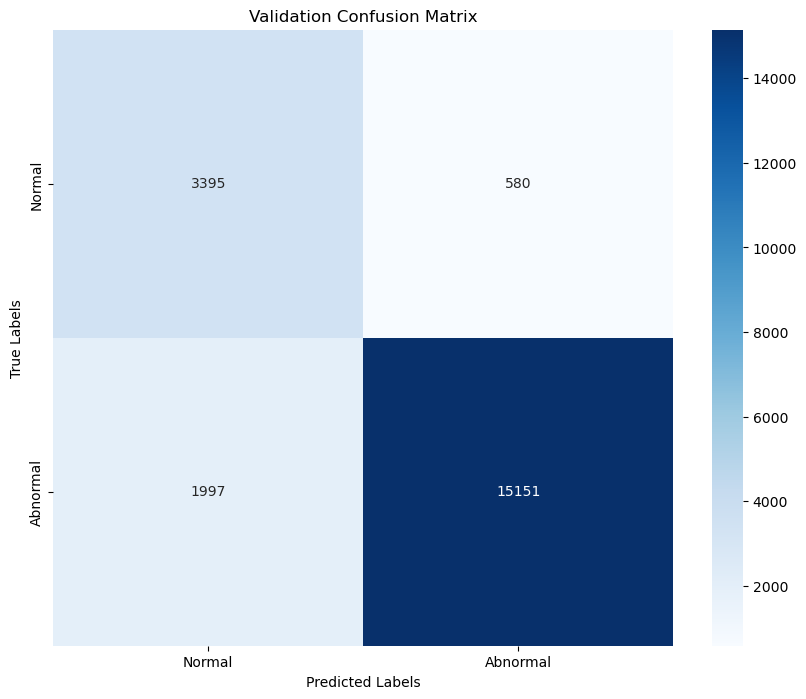

In [6]:
# Confusion Matrix for validation
val_cm = confusion_matrix(val_targets, val_predictions)
plt.figure(figsize=(10, 8))
sns.heatmap(val_cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Normal', 'Abnormal'], yticklabels=['Normal', 'Abnormal'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Validation Confusion Matrix')
plt.show()

Step 6: Test on Full Dataset

Test Precision: 0.9581
Test Recall: 0.9008
Test F1 Score: 0.9286


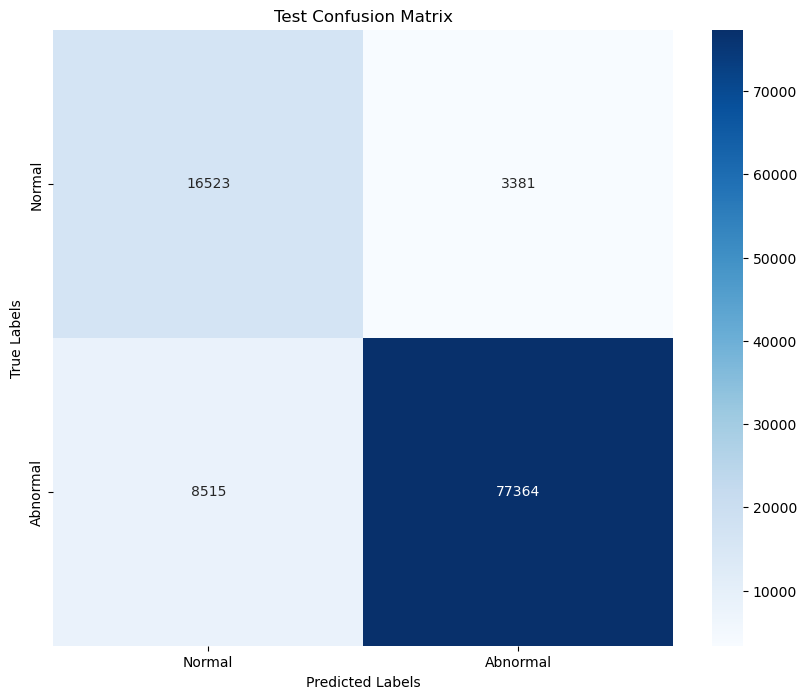

In [7]:
# Test on the full dataset in batches
test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=64, shuffle=False)

model.eval()
test_predictions = []
test_targets = []
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs.to(device))
        _, predictions = torch.max(outputs, 1)
        test_predictions.extend(predictions.cpu().numpy())
        test_targets.extend(labels.cpu().numpy())

# Metrics
test_precision = precision_score(test_targets, test_predictions)
test_recall = recall_score(test_targets, test_predictions)
test_f1 = f1_score(test_targets, test_predictions)

print(f'Test Precision: {test_precision:.4f}')
print(f'Test Recall: {test_recall:.4f}')
print(f'Test F1 Score: {test_f1:.4f}')

# Confusion Matrix for testing
test_cm = confusion_matrix(test_targets, test_predictions)
plt.figure(figsize=(10, 8))
sns.heatmap(test_cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Normal', 'Abnormal'], yticklabels=['Normal', 'Abnormal'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Test Confusion Matrix')
plt.show()

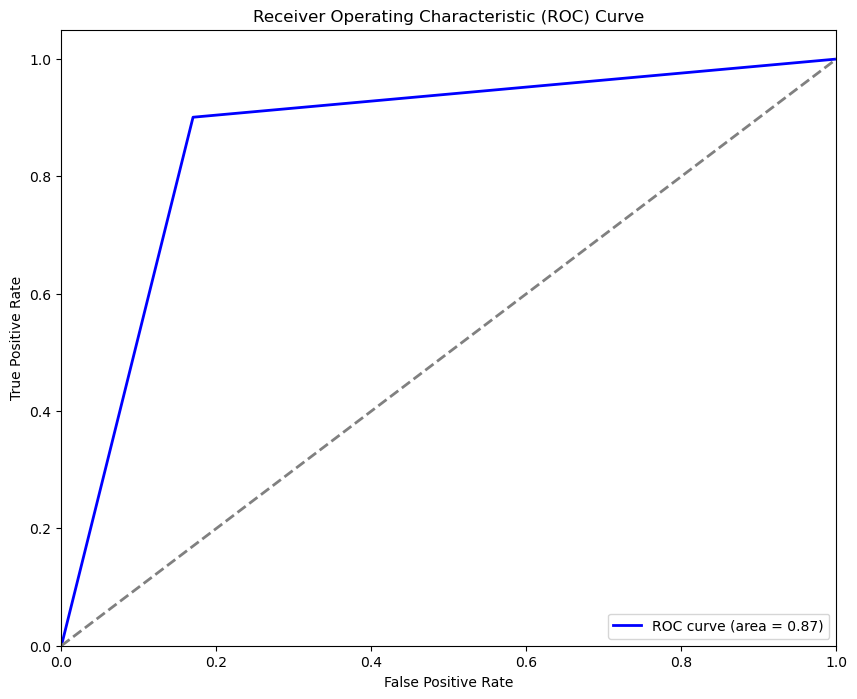

In [8]:
# ROC Curve
fpr, tpr, _ = roc_curve(test_targets, test_predictions)
roc_auc = roc_auc_score(test_targets, test_predictions)

plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()